<a href="https://colab.research.google.com/github/nwferreri/google-causal-impact/blob/main/google_causal_impact_VW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Causal Impact - Volkswagen CO2 Scandal

Use Causal Impact to measure the impact of the CO2 scandal in Volkswagen stock price.

1. Pick Stocks for the control groups
2. Perform a correlation matrix
3. Measure impact

##0. Libraries, Dates, and Data

In [ ]:
# Installing libraries
!pip install yfinance
!pip install tfcausalimpact

In [4]:
# Import libraries
import yfinance as yf
from causalimpact import CausalImpact
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
# Dates - Weekly intervals
training_start = '2014-01-08'
training_end = '2015-08-26'
treatment_start = '2015-09-02'
treatment_end = '2015-09-30'
end_stock = '2015-10-02'

In [6]:
# Download Volkswagen stock
y = ['VOW.DE']
y = yf.download(tickers=y,
                start=training_start,
                end=end_stock,
                interval='1wk')
y.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-06,194.050003,197.500000,192.550003,194.899994,125.620430,266513
2014-01-13,195.649994,197.850006,189.699997,197.350006,127.199547,468531
2014-01-20,196.350006,197.899994,184.899994,185.000000,119.239502,434638
2014-01-27,185.000000,189.899994,177.300003,180.350006,116.242401,514920
2014-02-03,180.899994,183.399994,171.949997,182.500000,117.628174,392696


In [7]:
y.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 91 entries, 2014-01-06 to 2015-09-28
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       91 non-null     float64
 1   High       91 non-null     float64
 2   Low        91 non-null     float64
 3   Close      91 non-null     float64
 4   Adj Close  91 non-null     float64
 5   Volume     91 non-null     int64  
dtypes: float64(5), int64(1)
memory usage: 5.0 KB


In [8]:
# Select only data we want
y = y['Adj Close'].rename('y')
y.head()

Date
2014-01-06    125.620430
2014-01-13    127.199547
2014-01-20    119.239502
2014-01-27    116.242401
2014-02-03    117.628174
Name: y, dtype: float64

##1. Pick stocks for control groups

In [9]:
# Load more stock data
stocks = ['META', 'DIS', 'NVS', 'AMZ']
X = yf.download(tickers=stocks,
                start=training_start,
                end=end_stock,
                interval='1wk')
X.head()

[*********************100%%**********************]  4 of 4 completed


Adj Close                                        Close  \
                   AMZ        DIS       META        NVS         AMZ   
Date                                                                  
2014-01-06  290.200012  69.382629  57.939999  50.780769  290.200012   
2014-01-13  296.000000  68.084999  56.299999  50.680878  296.000000   
2014-01-20  287.000000  66.925400  54.450001  49.844326  287.000000   
2014-01-27  271.299988  66.824150  62.570000  49.363598  271.299988   
2014-02-03  260.450012  69.640327  64.320000  50.518566  260.450012   

                                                   High             ...  \
                  DIS       META        NVS         AMZ        DIS  ...   
Date                                                                ...   
2014-01-06  75.389999  57.939999  72.885307  299.299988  76.279999  ...   
2014-01-13  73.980003  56.299999  72.741936  296.049988  75.129997  ...   
2014-01-20  72.720001  54.450001  71.541222  302.399994  75.430000  ...   
2014-01-27  72.610001  62.570000  70.851257  293.600006  73.629997  ...   
2014-02-03  75.669998  64.320000  72.508965  267.399994  76.730003  ...   

                  Low                   Open                                   \
                 META        NVS         AMZ        DIS       META        NVS   
Date                                                                            
2014-01-06  56.650002  71.030464  293.500000  76.129997  57.599998  71.505379   
2014-01-13  55.380001  71.980286  291.799988  74.900002  57.910000  72.526878   
2014-01-20  54.400002  71.370972  296.100006  73.989998  56.599998  72.921150   
2014-01-27  51.849998  70.277779  283.100006  72.470001  54.730000  71.200714   
2014-02-03  60.700001  69.802864  266.000000  72.660004  63.029999  71.568100   

             Volume                                 
                AMZ       DIS       META       NVS  
Date                                                
2014-01-06   5767.0  25172200  191385200   6043364  
2014-01-13  13308.0  33735400  209568900   6736734  
2014-01-20  22153.0  27918000  213174600   8419774  
2014-01-27  44300.0  36827300  453084400  15262974  
2014-02-03  54035.0  66118900  275328000  11256087  

[5 rows x 24 columns]

In [10]:
# Get relevant data
X = X.iloc[:, :len(stocks)]
X.columns = X.columns.droplevel()
X.head()

,AMZ,DIS,META,NVS
Date,,,,
2014-01-06,290.200012,69.382629,57.939999,50.780769
2014-01-13,296.000000,68.084999,56.299999,50.680878
2014-01-20,287.000000,66.925400,54.450001,49.844326
2014-01-27,271.299988,66.824150,62.570000,49.363598
2014-02-03,260.450012,69.640327,64.320000,50.518566


In [11]:
# Remove time zones
X.index = X.index.tz_localize(None)
X.index

DatetimeIndex(['2014-01-06', '2014-01-13', '2014-01-20', '2014-01-27',
               '2014-02-03', '2014-02-10', '2014-02-17', '2014-02-24',
               '2014-03-03', '2014-03-10', '2014-03-17', '2014-03-24',
               '2014-03-31', '2014-04-07', '2014-04-14', '2014-04-21',
               '2014-04-28', '2014-05-05', '2014-05-12', '2014-05-19',
               '2014-05-26', '2014-06-02', '2014-06-09', '2014-06-16',
               '2014-06-23', '2014-06-30', '2014-07-07', '2014-07-14',
               '2014-07-21', '2014-07-28', '2014-08-04', '2014-08-11',
               '2014-08-18', '2014-08-25', '2014-09-01', '2014-09-08',
               '2014-09-15', '2014-09-22', '2014-09-29', '2014-10-06',
               '2014-10-13', '2014-10-20', '2014-10-27', '2014-11-03',
               '2014-11-10', '2014-11-17', '2014-11-24', '2014-12-01',
               '2014-12-08', '2014-12-15', '2014-12-22', '2014-12-29',
               '2015-01-05', '2015-01-12', '2015-01-19', '2015-01-26',
      

In [12]:
# Combine everything
df = pd.concat([y, X], axis=1).dropna()
df.head()

,y,AMZ,DIS,META,NVS
Date,,,,,
2014-01-06,125.620430,290.200012,69.382629,57.939999,50.780769
2014-01-13,127.199547,296.000000,68.084999,56.299999,50.680878
2014-01-20,119.239502,287.000000,66.925400,54.450001,49.844326
2014-01-27,116.242401,271.299988,66.824150,62.570000,49.363598
2014-02-03,117.628174,260.450012,69.640327,64.320000,50.518566


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 88 entries, 2014-01-06 to 2015-09-28
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       88 non-null     float64
 1   AMZ     88 non-null     float64
 2   DIS     88 non-null     float64
 3   META    88 non-null     float64
 4   NVS     88 non-null     float64
dtypes: float64(5)
memory usage: 4.1 KB


##2. Correlation matrix

In [14]:
# Prepare training period data
df_training = df[df.index <= training_end]
df_training.tail()

,y,AMZ,DIS,META,NVS
Date,,,,,
2015-07-13,136.411560,445.350006,111.423409,94.970001,70.214943
2015-07-27,123.860603,484.250000,112.492081,94.010002,68.847954
2015-08-10,121.135063,478.299988,100.455437,94.419998,68.005180
2015-08-17,111.040489,445.049988,92.655968,86.059998,64.740303
2015-08-24,114.741837,465.399994,96.068245,91.010002,65.264534


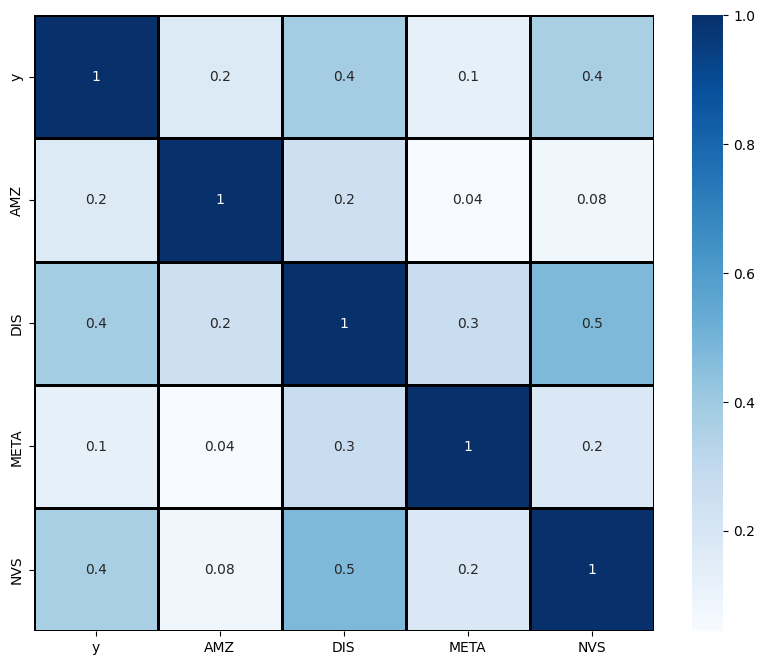

In [15]:
# Correlation matrix with differencing
plt.figure(figsize=(10, 8))
sns.heatmap(df_training.pct_change().dropna().corr(),
            annot=True,
            fmt='.1g',
            cmap='Blues',
            linewidths=1,
            linecolor='black');

META and AMZ are not strongly correlated, so they'll be removed.

##3. Measure impact

In [16]:
# Drop META and AMZ
df_final = df.drop(columns=['META', 'AMZ'])
df_final.head()

,y,DIS,NVS
Date,,,
2014-01-06,125.620430,69.382629,50.780769
2014-01-13,127.199547,68.084999,50.680878
2014-01-20,119.239502,66.925400,49.844326
2014-01-27,116.242401,66.824150,49.363598
2014-02-03,117.628174,69.640327,50.518566


**Weirdness**

The Causal Impact function fails because of mismatching dates.  We need to fix the dates.

In [17]:
# Get first and last dates
print(df_final.head(1))
print(df_final.tail(10))

                    y        DIS        NVS
Date                                       
2014-01-06  125.62043  69.382629  50.780769
                     y         DIS        NVS
Date                                         
2015-07-13  136.411560  111.423409  70.214943
2015-07-27  123.860603  112.492081  68.847954
2015-08-10  121.135063  100.455437  68.005180
2015-08-17  111.040489   92.655968  64.740303
2015-08-24  114.741837   96.068245  65.264534
2015-08-31  107.641975   94.652725  62.742882
2015-09-07  111.881699   97.943115  64.070061
2015-09-14  108.584152   96.405716  64.136421
2015-09-21   77.761993   94.024643  60.592831
2015-09-28   68.071182   96.555702  61.893475


In [18]:
# Modified Dates - they all needed to be the same day of the week except end_stock
training_start = "2014-01-06"
training_end = "2015-08-31"
treatment_start = "2015-09-07"
treatment_end = "2015-09-28"
end_stock = "2015-10-02"

In [19]:
# Pre and post period
pre_period = [training_start, training_end]
post_period = [treatment_start, treatment_end]

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))
Instructions for updating:
Please use `StructuralTimeSeries.joint_distribution(observed_time_series).log_prob`
Instructions for updating:
`Predictive distributions returned by`tfp.sts.one_step_predictive` will soon compute per-timestep probabilities (treating timesteps as part of the batch shape) instead of a single probability for an entire series (the current approach, in which timesteps are treated as event shape). Please update your code to pass `timesteps_are_event_shape=False` (this will soon be the default) and to explicitly sum over the per-timestep log probabilities if this is required.


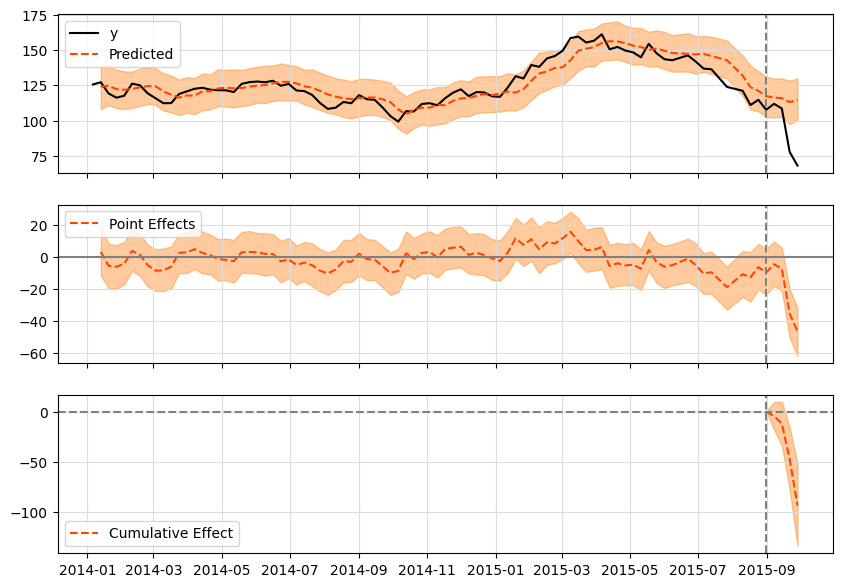

In [20]:
# Causal Impact
impact = CausalImpact(data=df_final,
                      pre_period=pre_period,
                      post_period=post_period)
impact.plot()

In [21]:
print(impact.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    91.57              366.3
Prediction (s.d.)         115.01 (5.19)      460.02 (20.75)
95% CI                    [104.81, 125.14]   [419.24, 500.56]

Absolute effect (s.d.)    -23.43 (5.19)      -93.72 (20.75)
95% CI                    [-33.57, -13.24]   [-134.26, -52.94]

Relative effect (s.d.)    -20.37% (4.51%)    -20.37% (4.51%)
95% CI                    [-29.19%, -11.51%] [-29.19%, -11.51%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


In [22]:
print(impact.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 91.57. By contrast, in the absence of an
intervention, we would have expected an average response of 115.01.
The 95% interval of this counterfactual prediction is [104.81, 125.14].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is -23.43 with a 95% interval of
[-33.57, -13.24]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 366.3.
By contrast, had the intervention not taken place, we would have expected
a sum of 460.02. The 95% interval of this prediction is [419.24, 500.56].


The above results are given in terms of absolute numbers. In relative
terms, the response v

## Conclusions

The CO2 scandal had a negative impact on the stock price of Volkswagen.  The analysis shows approximately a 20% drop in stock price.  The results are statistically significant.